Total points for this HW: 10

Make sure that you run all your codes and that all results are printed.

Please note: Copying and pasting other people's work is absolutely prohibited. Any such cases will be reported to CUSP's education team and severely punished. Discussion is encouraged, and feel free to exchange ideas with your classmates, but please write your own code and do your own work.

### Question 1 (40%)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10%)

2) The log marginal likelihood of the training data. (5%)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10%)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5%)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10%)


In [1]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [2]:
# your code here

In [3]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

1) The kernel after parameter optimization and fitting to the observed data. (10%)

In [4]:
# Preprocessing the data
Data1['log_traffic'] = np.log(Data1['AvgDailyTrafficCount'])
Data1['normalized_log_traffic'] = Data1['log_traffic'] - Data1['log_traffic'].mean()

In [5]:
# Extracting features and target variable
X_data = Data1[['Longitude', 'Latitude']].values
y_data = Data1['normalized_log_traffic'].values

In [6]:
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,log_traffic,normalized_log_traffic
0,-80.278366,40.468606,84.0,4.430817,-3.977559
1,-80.162117,40.384598,95.0,4.553877,-3.854499
2,-80.221205,40.366778,97.0,4.574711,-3.833665
3,-80.142455,40.622084,111.0,4.709530,-3.698846
4,-80.131975,40.544915,125.0,4.828314,-3.580062


In [7]:
# Defining kernel parameters
kernel_params = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e10))

In [8]:
# Training Gaussian Process model
gp_model = GaussianProcessRegressor(kernel=kernel_params, n_restarts_optimizer=10, random_state=559).fit(X_data, y_data)

2) The log marginal likelihood of the training data. (5%)

In [9]:
# Displaying results
print("Optimized kernel:", gp_model.kernel_)
print("Log marginal likelihood:", gp_model.log_marginal_likelihood_value_)

Optimized kernel: 0.662**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=0.567)
Log marginal likelihood: -1365.899681050507


3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10%)

In [10]:
import matplotlib.pyplot as plt

In [11]:
# Generating a grid for longitude and latitude
x_values = np.linspace(Data1['Longitude'].min(), Data1['Longitude'].max(), 100)
y_values = np.linspace(Data1['Latitude'].min(), Data1['Latitude'].max(), 100)
X_mesh, Y_mesh = np.meshgrid(x_values, y_values)
mesh_points = np.c_[X_mesh.ravel(), Y_mesh.ravel()]

In [12]:
# Instantiate and train Gaussian Process regressor
gp = GaussianProcessRegressor(kernel=kernel_params, n_restarts_optimizer=10, random_state=559).fit(X_data, y_data)

In [13]:
# Making predictions on the mesh grid
predicted_counts, std_deviation = gp.predict(mesh_points, return_std=True)
predicted_counts_mesh = predicted_counts.reshape(X_mesh.shape)

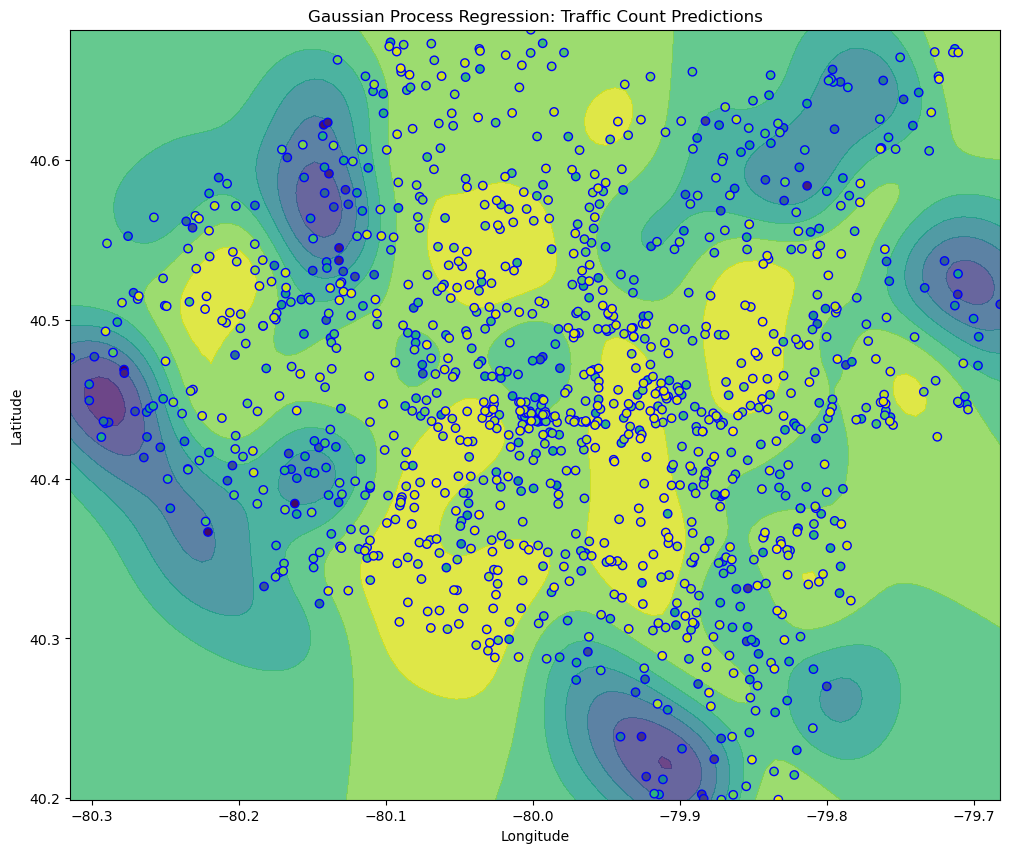

In [14]:
# Visualizing predictions
plt.figure(figsize=(12, 10))
contour_plot = plt.contourf(X_mesh, Y_mesh, predicted_counts_mesh, cmap='viridis', alpha=0.8)
scatter_plot = plt.scatter(Data1['Longitude'], Data1['Latitude'], c=Data1['normalized_log_traffic'], cmap='viridis', edgecolor='b')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Gaussian Process Regression: Traffic Count Predictions')
plt.show()

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5%)

In [15]:
# Making predictions using the Gaussian Process model
Data1['Predicted'] = gp.predict(Data1[['Longitude', 'Latitude']].values)

# Calculating Z-scores
Data1['Z_score'] = (Data1['normalized_log_traffic'] - Data1['Predicted'].mean()) / Data1['Predicted'].std()

# Identifying outliers
outliers = Data1[np.abs(Data1['Z_score']) > 2.0]

# Calculating the percentage of sensors with traffic counts more than two standard deviations from the model prediction
outlier_percentage = 100 * len(outliers) / len(Data1)

# Displaying the percentage of outliers
print("Percentage of sensors with average traffic counts more than two standard deviations higher or lower than the model prediction is:")
print("{:.2f}%".format(outlier_percentage))

Percentage of sensors with average traffic counts more than two standard deviations higher or lower than the model prediction is:
13.45%


5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10%)

In [16]:
# Filtering data points
above = Data1[Data1['Z_score'] > 2.0]
below = Data1[Data1['Z_score'] < -2.0]
between = Data1[abs(Data1['Z_score']) <= 2.0]

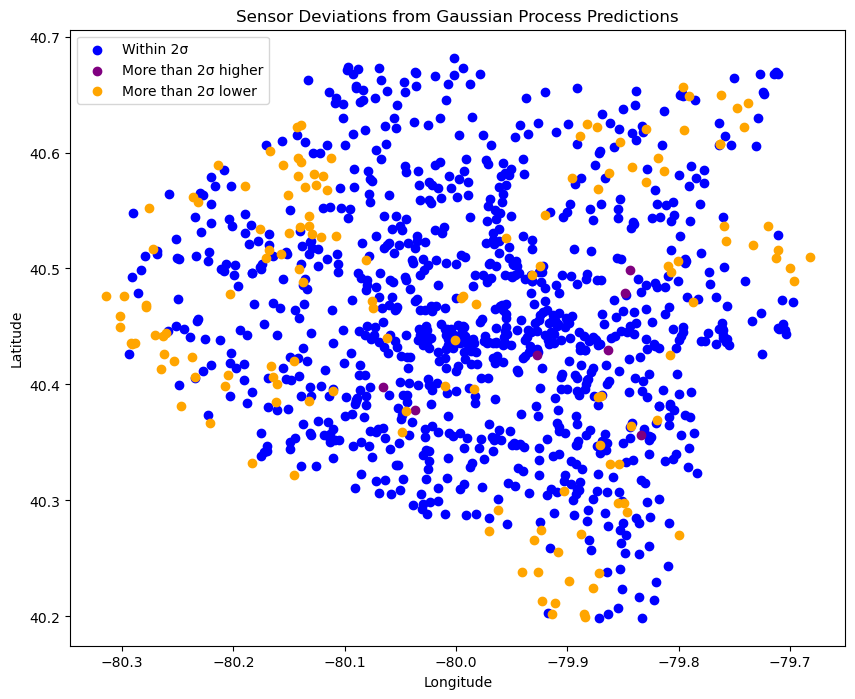

In [17]:
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(between['Longitude'], between['Latitude'], color='blue', label='Within 2σ')
plt.scatter(above['Longitude'], above['Latitude'], color='purple', label='More than 2σ higher')
plt.scatter(below['Longitude'], below['Latitude'], color='orange', label='More than 2σ lower')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Sensor Deviations from Gaussian Process Predictions')
plt.show()

### Question 2: Cluster-based anomaly detection (10%)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 1

B: 150 points, center (35, 5), standard deviation 5

C: 200 points, center (15, 20), standard deviation 0.1

D: 2 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


In [18]:
# Your solutions here

Point (1, 0)
Cluster A: Center (0, 0), Standard Deviation 1
Distance from the center of cluster A = sqrt((1-0)^2 + (0-0)^2) = 1
This distance is about 1 standard deviation from the center. Given the size and variance of Cluster A, this point is likely not an anomaly.


Point (35, 2)
Cluster B: Center (35, 5), Standard Deviation 5
Distance from the center of cluster B = sqrt((35-35)^2 + (2-5)^2) = 3
This distance is less than 1 standard deviation from the center. Given the large size and variance of Cluster B, this point is likely not an anomaly.


Point (15, 19)
Cluster C: Center (15, 20), Standard Deviation 0.1
Distance from the center of cluster C = sqrt((15-15)^2 + (19-20)^2) = 1
This distance is 10 standard deviations from the center (far exceeding the typical range for a Gaussian distribution which often considers points within about 3 standard deviations from the mean). Despite being the closest cluster, this extreme deviation in a cluster with a very small standard deviation indicates this point is likely an anomaly.


Point (10, 11)
Cluster D: Center (10, 10), Standard Deviation 1
Distance from the center of cluster D = sqrt((10-10)^2 + (11-10)^2) = 1
This distance is 1 standard deviation from the center. However, considering Cluster D consists of only 2 points, it itself might represent anomalies or a very distinct subgroup. The proximity of this point to Cluster D's center, however, suggests it might belong to this cluster and thus this point is likely not an anomaly based on Cluster D's attributes.


Summary

(1, 0): Not Anomaly

(35, 2): Not Anomaly

(15, 19): Anomaly

(10, 11): Not Anomaly

### Question 3: Anomaly detection (50%)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5%) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10%)

Part 2: Cluster based anomaly detection. Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10%)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10%)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10%)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5%)

In [19]:
Data2=pd.read_csv("CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [20]:
# your code here

In [21]:
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

In [22]:
# Selecting relevant columns and renaming them
Data2 = Data2[["County","'\% Smokers'","'\% Obese'",\
       "'Violent Crime Rate'", "'80/20 Income Ratio'", \
       "'\% Children in Poverty'", "'Average Daily PM2.5'"]]
column_names = ['county','smokers', 'obese', 'violent_crime_rate', 'income_ratio', 'children_poverty', 'avg_pm2.5']
Data2.columns = column_names

# Converting columns to numeric and handling missing values
Data2.iloc[:,1:] = np.array(Data2.iloc[:,1:].apply(pd.to_numeric, errors='coerce', downcast='integer'))
Data2.dropna(inplace=True, how='any')

# Binning numeric columns into categories
Data2.iloc[:,1:] = Data2.iloc[:,1:].apply(pd.cut, bins=5, labels=[0, 1, 2, 3, 4]).astype(int)

In [23]:
# Displaying the first few rows of the DataFrame
Data2.head()

,county,smokers,obese,violent_crime_rate,income_ratio,children_poverty,avg_pm2.5
0,"Autauga, Alabama",1,2,0,1,1,3
1,"Baldwin, Alabama",1,2,0,1,1,3
2,"Barbour, Alabama",2,4,0,2,3,3
3,"Bibb, Alabama",2,4,0,1,2,3
4,"Blount, Alabama",1,2,0,1,1,3


(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5%) 

In [24]:
# Performing Hill Climbing Search
hill_climb = HillClimbSearch(Data2)
best_model = hill_climb.estimate(scoring_method='BicScore')

# Printing the edges of the best model
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('smokers', 'children_poverty'), ('smokers', 'avg_pm2.5'), ('obese', 'smokers'), ('children_poverty', 'income_ratio'), ('children_poverty', 'violent_crime_rate')]


In [25]:
# Creating a Bayesian Network based on the best model
bayesian_network = BayesianNetwork(best_model.edges())

# Fitting the Bayesian Network to the data using Maximum Likelihood Estimator
bayesian_network.fit(Data2, estimator=MaximumLikelihoodEstimator)

# Printing the Conditional Probability Distributions (CPDs) of each variable in the model
for cpd in bayesian_network.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of smokers:
+------------+----------+-----+---------------------+
| obese      | obese(0) | ... | obese(4)            |
+------------+----------+-----+---------------------+
| smokers(0) | 0.48     | ... | 0.0                 |
+------------+----------+-----+---------------------+
| smokers(1) | 0.52     | ... | 0.1044776119402985  |
+------------+----------+-----+---------------------+
| smokers(2) | 0.0      | ... | 0.7164179104477612  |
+------------+----------+-----+---------------------+
| smokers(3) | 0.0      | ... | 0.13432835820895522 |
+------------+----------+-----+---------------------+
| smokers(4) | 0.0      | ... | 0.04477611940298507 |
+------------+----------+-----+---------------------+
CPD of children_poverty:
+---------------------+-----+---------------------+------------+
| smokers             | ... | smokers(3)          | smokers(4) |
+---------------------+-----+---------------------+------------+
| children_poverty(0) | ... | 0.0                 | 0.0       

In [26]:
Data2.iloc[:,1:]

,smokers,obese,violent_crime_rate,income_ratio,children_poverty,avg_pm2.5
0,1,2,0,1,1,3
1,1,2,0,1,1,3
2,2,4,0,2,3,3
3,2,4,0,1,2,3
4,1,2,0,1,1,3
...,...,...,...,...,...,...
3136,1,2,1,1,0,3
3137,1,0,0,0,0,1
3138,1,2,0,1,0,2
3139,1,1,0,1,1,1


(b) Which 5 counties have the lowest (most negative) log-likelihood values? 
Please show a ranked list of the top counties' names and log-likelihood values. (10%)

In [41]:
def LL(x,bayesian_network,verbose=False):
    loglike = 0
    for cpd in bayesian_network.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = bayesian_network.predecessors(thevariable)
        theparents_list = []
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
            theparents_list.append(parent)
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print(thevariable,theparents_list,theprob)
        loglike += np.log(theprob)
    return loglike
# Apply the function to calculate the log-likelihood for each row
Data2['loglike'] = Data2.iloc[:, 1:].apply(lambda x: LL(x, bayesian_network), axis=1)

# Sort by log_likelihood to find the most negative values, indicating anomalies
print(Data2.sort_values('loglike')['county'].head(5))

1856                            New York, New York
1227                        Suffolk, Massachusetts
221                      San Francisco, California
317     District of Columbia, District of Columbia
2027                        Roulette, North Dakota
Name: county, dtype: object


(a) Clustering with k-means. Please use k=3 clusters. 
Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10%)

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore')

In [33]:
# Load and preprocess the data
data_full = pd.read_csv('CountyHealthIndicators.csv').dropna()
data_full_numeric = data_full.select_dtypes(include=[np.number])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_full_numeric)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=999)
cluster_labels = kmeans.fit_predict(data_full_numeric)

# Compute distances from cluster centers
distances = kmeans.transform(data_full_numeric)
res = pd.DataFrame(distances)
res = pd.concat((res, pd.DataFrame(cluster_labels)), axis=1)
res.columns = list(range(3)) + ["cluster"]
res.loc[:, "score"] = res.apply(lambda x: x[int(x["cluster"])], axis=1)

# Find top 5 counties with the highest k-means distance
print("Top 5 counties by k-means distance:")
top_counties = res.sort_values("score", ascending=False)[:5].index
print(data_full.iloc[top_counties]['County'])

Top 5 counties by k-means distance:
1697            Hooker, Nebraska
90          Wade Hampton, Alaska
70                Bethel, Alaska
269           Hinsdale, Colorado
84      Northwest Arctic, Alaska
Name: County, dtype: object


(b) Cluster with Gaussian Mixture. 
#Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10%)

In [34]:
from sklearn.mixture import GaussianMixture

In [35]:
# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=999)
gmm.fit(data_full_numeric)

# Calculate GMM log-likelihood for each county
data_full['GMM_log_likelihood'] = gmm.score_samples(data_full_numeric)

# Display top 5 anomalous counties by GMM log-likelihood
print("Top 5 counties by GMM log-likelihood:")
print(data_full.sort_values('GMM_log_likelihood')['County'].head(5))

Top 5 counties by GMM log-likelihood:
90       Wade Hampton, Alaska
70             Bethel, Alaska
1697         Hooker, Nebraska
2415    Shannon, South Dakota
93      Yukon-Koyukuk, Alaska
Name: County, dtype: object


Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10%)

In [36]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [37]:
# Fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(data_scaled)

# Get anomaly scores
anomaly_scores = iso_forest.decision_function(data_scaled)

# Convert scores to positive, as lower scores are more anomalous
anomaly_scores = -anomaly_scores

# Get the indices of the top 5 counties with the highest anomaly scores
top_indices = anomaly_scores.argsort()[:5]

# Print the top 5 anomalous counties
print("Top 5 anomalous counties by Isolation Forest:")
print(data_full.iloc[top_indices]['County'])

Top 5 anomalous counties by Isolation Forest:
1553           Newton, Missouri
1015            Clark, Kentucky
2341    Kershaw, South Carolina
2579          Deaf Smith, Texas
2063            Fairfield, Ohio
Name: County, dtype: object


Part 4: Compare and contrast the results from the different models. Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5%)

Counties that were found to be anomalous by both GMM and k-means:
Hooker, Nebraska
Wade Hampton, Alaska
Bethel, Alaska
Hinsdale, Colorado
Northwest Arctic, Alaska

This shows that their health indicators are notable not only for their pattern (GMM), but also for their size (k-mean).

Differences in outcomes may be due to fundamental properties of each model.

Isolation Forest is capable of detecting anomalies with local uniqueness, even if they are not far from cluster centers.
GMM excels in detecting anomalies that may not appear as extreme outliers in terms of distance but are highly unlikely given the form of Gaussian distributions.
k-Means prioritizes outliers in terms of values above unusual patterns.